# Import

In [32]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, AveragePooling2D, Lambda
from urllib import request
from keras.callbacks import TensorBoard, ModelCheckpoint
import tempfile
from keras import optimizers
from keras.utils import Sequence
import numpy as np
from tqdm import tqdm
from datetime import datetime
from keras.applications import vgg16, resnet50
from glob import glob
from IPython.display import Image
import json

# Utils

In [33]:
def mkdir(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define parameters

In [34]:
ROOT_DIR = './data/dog-breed'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
MODELS_DIR = './data/models/2/'
LOGS_DIR = './data/logs/'

EPOCHS = 50
BATCH_SIZE = 1024
IMAGE_SIZE = (224,224)
INPUT_SHAPE = IMAGE_SIZE + (3,)

mkdir(MODELS_DIR)

# Fetch data (if not exist)

In [35]:
def fetch_data():
    if not os.path.exists(ROOT_DIR):
        os.makedirs(ROOT_DIR)
        zip_path = os.path.join(tempfile.gettempdir(), 'dog-breed.zip')
        print('Start download!')
        request.urlretrieve('https://kienle.blob.core.windows.net/public/kaggle/dog-breed.zip', zip_path)
        print('Start unzip')
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'test.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'train.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        os.remove(zip_path)
        os.remove(os.path.join(ROOT_DIR,'train.zip'))
        os.remove(os.path.join(ROOT_DIR,'test.zip'))
        print('Done')
fetch_data()

In [5]:
# Confirm all data are ready 
# Expected output: labels.csv  sample_submission.csv  test  train
!ls $ROOT_DIR

labels.csv  sample_submission.csv  test  train


# Explore dataset

In [36]:
pd_images = pd.read_csv(os.path.join(ROOT_DIR, 'labels.csv'))

In [37]:
pd_images.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


dingo


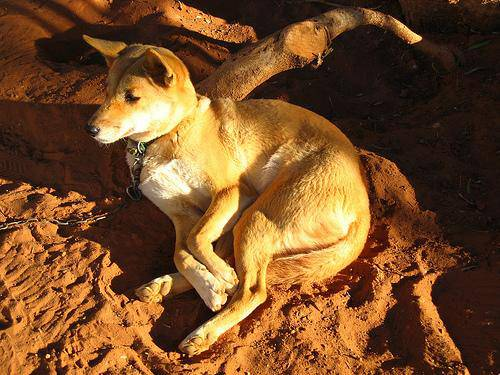

In [39]:
title = pd_images.breed[1]
path = os.path.join(TRAIN_DIR, pd_images.id[1] + '.jpg')
print(title)
Image(filename=path)

# Load images by ImageDataGenerator

In [9]:
image_gen = ImageDataGenerator()

In [10]:
train_valid_generator = image_gen.flow_from_dataframe(pd_images, TRAIN_DIR, batch_size=BATCH_SIZE, x_col='id', y_col='breed', has_ext=False, target_size=IMAGE_SIZE)

Found 10222 images belonging to 120 classes.


In [11]:
num_classes = len(train_valid_generator.class_indices)

In [12]:
train_valid_generator.class_indices

{'boston_bull': 0,
 'dingo': 1,
 'pekinese': 2,
 'bluetick': 3,
 'golden_retriever': 4,
 'bedlington_terrier': 5,
 'borzoi': 6,
 'basenji': 7,
 'scottish_deerhound': 8,
 'shetland_sheepdog': 9,
 'walker_hound': 10,
 'maltese_dog': 11,
 'norfolk_terrier': 12,
 'african_hunting_dog': 13,
 'wire-haired_fox_terrier': 14,
 'redbone': 15,
 'lakeland_terrier': 16,
 'boxer': 17,
 'doberman': 18,
 'otterhound': 19,
 'standard_schnauzer': 20,
 'irish_water_spaniel': 21,
 'black-and-tan_coonhound': 22,
 'cairn': 23,
 'affenpinscher': 24,
 'labrador_retriever': 25,
 'ibizan_hound': 26,
 'english_setter': 27,
 'weimaraner': 28,
 'giant_schnauzer': 29,
 'groenendael': 30,
 'dhole': 31,
 'toy_poodle': 32,
 'border_terrier': 33,
 'tibetan_terrier': 34,
 'norwegian_elkhound': 35,
 'shih-tzu': 36,
 'irish_terrier': 37,
 'kuvasz': 38,
 'german_shepherd': 39,
 'greater_swiss_mountain_dog': 40,
 'basset': 41,
 'australian_terrier': 42,
 'schipperke': 43,
 'rhodesian_ridgeback': 44,
 'irish_setter': 45,
 'a

# Feature extractions using pretrained models

In [40]:
def FeaturesExtractor(input_shape, pretrained_model, preprocess_input):
    model = pretrained_model(include_top=False, input_shape=input_shape, weights='imagenet')
    inputs = Input(input_shape)
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = model(x)
    x = GlobalAveragePooling2D()(x)
    return Model(inputs, x)

# Prepare training dataset

In [41]:
X_train = np.zeros((train_valid_generator.n,) + INPUT_SHAPE)
y_train = np.zeros((train_valid_generator.n, 120))
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    temp_x, temp_y = train_valid_generator[i]
    start_index = i*train_valid_generator.batch_size
    X_train[start_index:start_index + temp_x.shape[0]] = temp_x
    y_train[start_index:start_index + temp_x.shape[0]] = temp_y


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.78s/it]


# Model creation function

In [42]:
def create_simple_model(num_classes, input_shape):
    inputs = Input(input_shape)
    x = inputs
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, x)

# Use vgg16

In [43]:
vgg_features_extractor = FeaturesExtractor(INPUT_SHAPE, vgg16.VGG16, vgg16.preprocess_input)

In [44]:
# Calculate vgg features
vgg_features = vgg_features_extractor.predict(X_train)
vgg_features.shape

In [46]:
vgg_features.shape
X_train.shape

(10222, 224, 224, 3)

In [47]:
vgg_based_model = create_simple_model(num_classes, vgg_features_extractor.output.get_shape().as_list()[1:])
vgg_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath= MODELS_DIR + "model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [TensorBoard( LOGS_DIR +'vgg-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0])),
            checkpoint
            ]
    
vgg_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 61,560
Trainable params: 61,560
Non-trainable params: 0
_________________________________________________________________


In [48]:
vgg_based_model.fit(vgg_features, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 0s 54us/step - loss: 15.0890 - acc: 0.0123 - val_loss: 13.5395 - val_acc: 0.0293

Epoch 00001: val_acc improved from -inf to 0.02933, saving model to ./data/models/2/model-weights-01-0.03.hdf5
Epoch 2/50
9199/9199 [==============================] - 0s 6us/step - loss: 14.4918 - acc: 0.0272 - val_loss: 12.7558 - val_acc: 0.0577

Epoch 00002: val_acc improved from 0.02933 to 0.05767, saving model to ./data/models/2/model-weights-02-0.06.hdf5
Epoch 3/50
9199/9199 [==============================] - 0s 7us/step - loss: 14.1300 - acc: 0.0329 - val_loss: 11.8983 - val_acc: 0.0811

Epoch 00003: val_acc improved from 0.05767 to 0.08113, saving model to ./data/models/2/model-weights-03-0.08.hdf5
Epoch 4/50
9199/9199 [==============================] - 0s 7us/step - loss: 13.5351 - acc: 0.0489 - val_loss: 10.6962 - val_acc: 0.1193

Epoch 00004: val_acc improved from 0.08113 to 0.11926, saving mo

9199/9199 [==============================] - 0s 7us/step - loss: 3.1541 - acc: 0.5740 - val_loss: 2.5652 - val_acc: 0.6334

Epoch 00034: val_acc did not improve from 0.64418
Epoch 35/50
9199/9199 [==============================] - 0s 7us/step - loss: 3.0515 - acc: 0.5841 - val_loss: 2.5067 - val_acc: 0.6393

Epoch 00035: val_acc did not improve from 0.64418
Epoch 36/50
9199/9199 [==============================] - 0s 8us/step - loss: 2.9062 - acc: 0.5914 - val_loss: 2.4827 - val_acc: 0.6403

Epoch 00036: val_acc did not improve from 0.64418
Epoch 37/50
9199/9199 [==============================] - 0s 6us/step - loss: 2.8551 - acc: 0.6006 - val_loss: 2.4221 - val_acc: 0.6354

Epoch 00037: val_acc did not improve from 0.64418
Epoch 38/50
9199/9199 [==============================] - 0s 7us/step - loss: 2.7730 - acc: 0.6009 - val_loss: 2.4204 - val_acc: 0.6520

Epoch 00038: val_acc improved from 0.64418 to 0.65200, saving model to ./data/models/2/model-weights-38-0.65.hdf5
Epoch 39/50
9199/9

# Use resnet50

In [49]:
resnet50_features_extractor = FeaturesExtractor(INPUT_SHAPE, resnet50.ResNet50, resnet50.preprocess_input)

/home/trule/miniconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [50]:
resnet50_features = resnet50_features_extractor.predict(X_train)

In [51]:
resnet50_features.shape

(10222, 2048)

In [52]:
resnet50_based_model = create_simple_model(num_classes, resnet50_features_extractor.output.get_shape().as_list()[1:])
resnet50_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [TensorBoard(LOGS_DIR +'resnet50-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]

In [53]:
resnet50_based_model.fit(resnet50_features, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,  callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 1s 82us/step - loss: 5.1951 - acc: 0.0401 - val_loss: 3.4898 - val_acc: 0.2199
Epoch 2/50
9199/9199 [==============================] - 0s 11us/step - loss: 3.3658 - acc: 0.2229 - val_loss: 2.1893 - val_acc: 0.5357
Epoch 3/50
9199/9199 [==============================] - 0s 12us/step - loss: 2.2623 - acc: 0.4270 - val_loss: 1.5378 - val_acc: 0.6481
Epoch 4/50
9199/9199 [==============================] - 0s 13us/step - loss: 1.6808 - acc: 0.5456 - val_loss: 1.2274 - val_acc: 0.6960
Epoch 5/50
9199/9199 [==============================] - 0s 12us/step - loss: 1.3597 - acc: 0.6229 - val_loss: 1.0673 - val_acc: 0.7107
Epoch 6/50
9199/9199 [==============================] - 0s 11us/step - loss: 1.1369 - acc: 0.6826 - val_loss: 0.9798 - val_acc: 0.7361
Epoch 7/50
9199/9199 [==============================] - 0s 11us/step - loss: 1.0001 - acc: 0.7174 - val_loss: 0.9157 - val_acc: 0.7419
Epoch 8

# Confusion matrix (VGG)

In [54]:
index2labels = {}
for k, v in train_valid_generator.class_indices.items():
    index2labels[v] = k

In [55]:
preds = []
targets = []
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    x, y = train_valid_generator[i]
    p = vgg_based_model.predict(vgg_features_extractor.predict(x))
    p = np.argmax(p, axis=1)    
    y = np.argmax(y, axis=1)
    preds = np.concatenate((preds, p))
    targets = np.concatenate((targets, y))
from sklearn.metrics import confusion_matrix
print(np.sum(targets == preds))
print(preds[0:10])
print(targets[0:10])
cm = confusion_matrix(targets, preds)
print(cm[0:10, 0:10])

100%|█████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.64s/it]

8888
[ 88.  48.  56.  54.  98.  89.  82.  94. 103.  99.]
[ 88.  48.  56.  54.  98.   1.  82.  94. 103.  79.]
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1   0   0   6   0   0]
 [  0   0  61   0   0   0   0   0   0   0]
 [  0   0   0  78   0   0   0   0   0   0]
 [  0   0   0   0  61   0   0   0   0   0]
 [  0   0   0   0   0  79   0   0   0   0]
 [  0   0   0   0   0   0  66   0   0   0]
 [  0   0   0   0   0   0   0 102   0   0]
 [  0   0   0   0   0   0   0   0 108   0]
 [  0   0   0   0   0   0   0   0   0  64]]


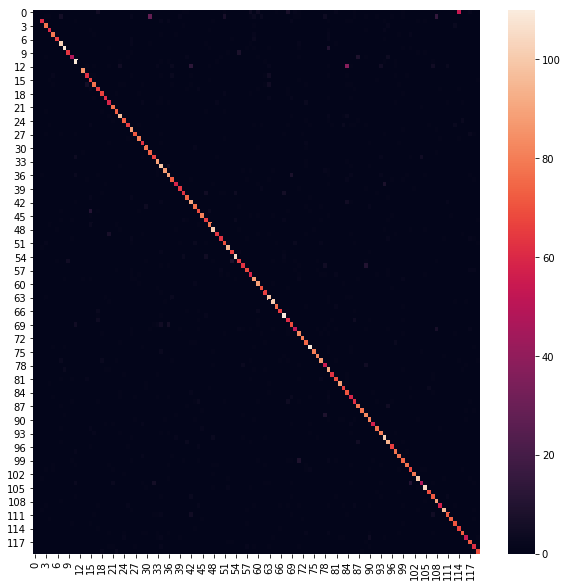

In [56]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=False)

# Save models and data for prediction

In [30]:
# vgg_features_extractor.save(MODELS_DIR + 'model-weights-vgg_features_extractor.hdf5')

In [31]:
with open(MODELS_DIR + 'model-classes.json', 'w') as f:
    f.write(json.dumps(train_valid_generator.class_indices))